# Classification with BERT 

The following Notebook shows how to classify the data using pretrained BERT model for encoding the text. It is STRONGLY recommended you run this notebook on Colab as you will need a GPU most likely to train this model. 

Make sure you have installed all dependencies.

In [1]:
import seaborn as sns
from matplotlib import rc
from pylab import rcParams

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [2]:
import pandas as pd

df = pd.read_csv("./data/training.csv")
test_df = pd.read_csv("./data/testing.csv")

df.head()

,text,1-RAPPORT,2-NEGOTIATE,3-EMOTION,4-LOGIC,5-AUTHORITY,6-SOCIAL,7-PRESSURE,8-NO-PERSUASION
0,Hi.,0,0,0,0,0,0,0,1
1,not much.,0,0,0,0,0,0,0,1
2,do you donate to any charities,1,0,0,0,0,0,0,0
3,Howmuch do you think you can donate,0,1,0,0,0,0,0,0
4,That's great.,1,0,0,0,0,0,0,0


The training df can be split into a training and evaluation set for training. 

In [3]:
from sklearn.model_selection import train_test_split

train_df, eval_df = train_test_split(df, test_size=0.05)
print(f'Num Training {len(train_df)}')
print(f'Num Evaluation {len(eval_df)}')

Num Training 7367
Num Evaluation 388


# Visualising the Data 
We can have a look at the data and the distribution of tags

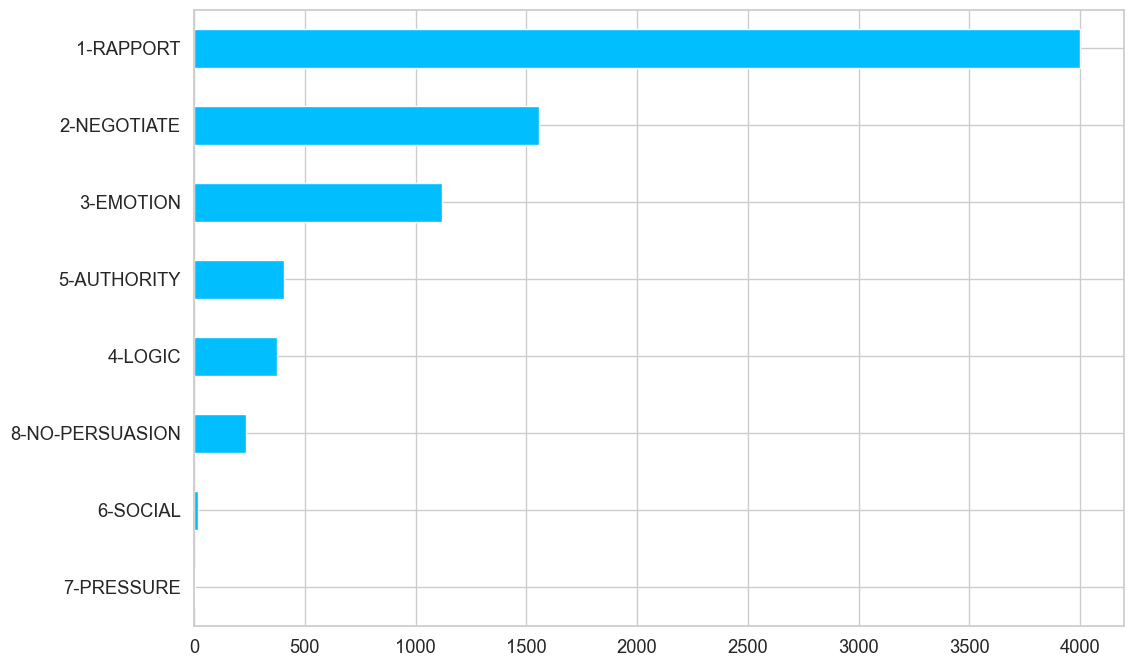

In [4]:
import matplotlib.pyplot as plt

LABEL_COLUMNS = df.columns.tolist()[1:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

# !Need to add a balancing script ROB!

# Preprocessing Data using BERT Tokenizer

In [5]:
try:
  from transformers import BertTokenizer
except:
  !pip install transformers
finally:
    !clear

In [6]:
from transformers import BertTokenizer

In [7]:
BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

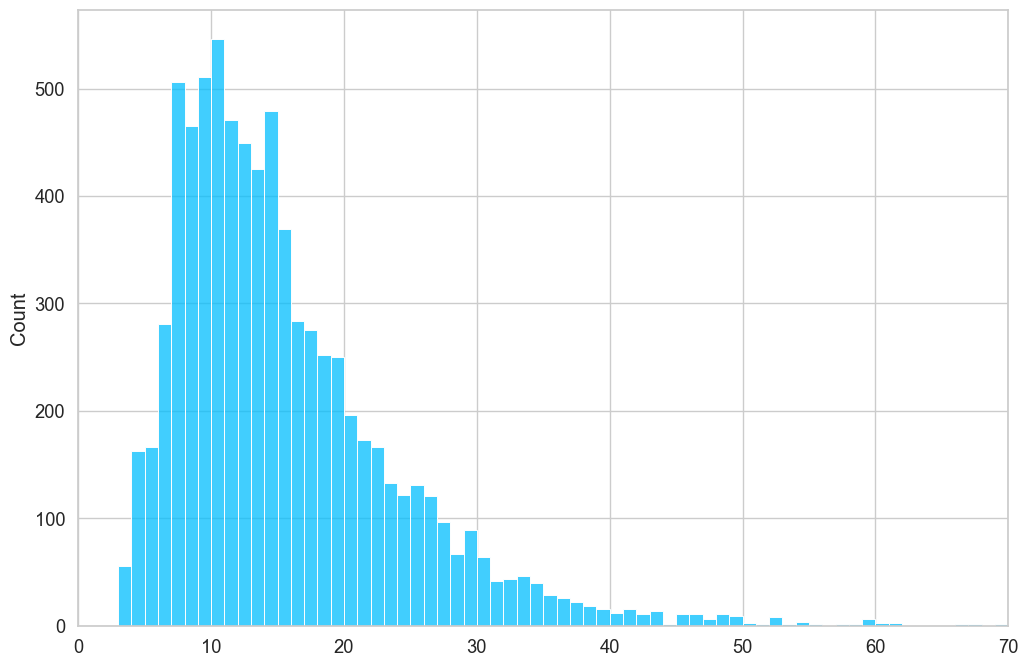

In [8]:
def visualise_tokencounts(df, column_name, max_tokens):

    token_counts = []

    for _, row in df.iterrows():

        token_count = len(tokenizer.encode(
        row[column_name],
        max_length=max_tokens+50,
        truncation=True

      ))

        token_counts.append(token_count)
    sns.histplot(token_counts)
    plt.xlim([0, max_tokens]);
    
visualise_tokencounts(df, 'text', 70)



In [9]:
MAX_TOKEN_COUNT = 70

# Create Datasets using Pytorch_lightning Module

In [10]:
try:
  import pytorch_lightning
except:
  !pip install pytorch_lightning
finally:
    !clear

In [11]:
import sys
sys.path.append('code')

from BERT_Module import PersuasionStrategiesModule

In [12]:
N_EPOCHS = 10
BATCH_SIZE = 32

data_module = PersuasionStrategiesModule(
  train_df,
  eval_df,
  test_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT

)


In [13]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [14]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(460, 2300)

## Initialising Model 

In [15]:
from BERT_Module import PersuasionStrategiesClassifier

In [18]:
model = PersuasionStrategiesClassifier(

  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps

)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

KeyboardInterrupt: 

# Training 
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy,auroc
from torchmetrics.functional import f1_score as f1

In [ ]:
checkpoint_callback = ModelCheckpoint(

  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"

)

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="persuasion-strategies")
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
trainer = pl.Trainer(

  logger=logger,
  callbacks=[early_stopping_callback, checkpoint_callback],
  max_epochs=N_EPOCHS,
  accelerator = 'gpu',
    
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 109 M 
1 | classifier | Linear    | 6.2 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.954   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 195: 'val_loss' reached 0.27990 (best 0.27990), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 390: 'val_loss' reached 0.17340 (best 0.17340), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 585: 'val_loss' reached 0.14854 (best 0.14854), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 780: 'val_loss' reached 0.14481 (best 0.14481), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 975: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1170: 'val_loss' was not in top 1


In [ ]:
import torch
from BERT_Module import PersuasionStrategyDataset
from tqdm.auto import tqdm
import numpy as np

In [ ]:
trained_model = PersuasionStrategiesClassifier.load_from_checkpoint(

  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)

)

trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
val_dataset = PersuasionStrategyDataset(

  test_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT

)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)

  )

  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/892 [00:00<?, ?it/s]

In [ ]:
print("AUROC per tag")

for i, name in enumerate(LABEL_COLUMNS):

  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)

  print(f"{name}: {tag_auroc}")

AUROC per tag
1-RAPPORT: 0.885923445224762
2-NEGOTIATE: 0.9186205267906189
3-EMOTION: 0.8593864440917969
4-LOGIC: 0.9977527856826782
5-AUTHORITY: 1.0
6-SOCIAL: 0.37837839126586914
7-PRESSURE: 0.0
8-NO-PERSUASION: 0.7937789559364319


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


In [ ]:
from sklearn.metrics import classification_report

THRESHOLD = 0.5

y_pred = predictions.numpy()
y_true = labels.numpy()
upper, lower = 1, 0
y_pred = np.where(y_pred > THRESHOLD, upper, lower)
print(classification_report(

  y_true,
  y_pred,
  target_names=LABEL_COLUMNS,
  zero_division=0

))

                 precision    recall  f1-score   support

      1-RAPPORT       0.84      0.76      0.80       314
    2-NEGOTIATE       0.87      0.68      0.76       132
      3-EMOTION       0.59      0.73      0.66        52
        4-LOGIC       0.00      0.00      0.00         2
    5-AUTHORITY       0.67      1.00      0.80         4
       6-SOCIAL       0.00      0.00      0.00         4
     7-PRESSURE       0.00      0.00      0.00         0
8-NO-PERSUASION       0.84      0.65      0.73       510

      micro avg       0.83      0.69      0.75      1018
      macro avg       0.48      0.48      0.47      1018
   weighted avg       0.83      0.69      0.75      1018
    samples avg       0.79      0.72      0.74      1018



In [ ]:
from torch.nn import Softmax

S = Softmax(dim=1)

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [ ]:
test_comment = """I would hate to think a child would die with no food when I could ask people to help"""

In [ ]:
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
encoding = tokenizer.encode_plus(

  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',

)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

1-RAPPORT: 0.06336382776498795
2-NEGOTIATE: 0.03868960589170456
3-EMOTION: 0.9234907627105713
4-LOGIC: 0.06143007427453995
5-AUTHORITY: 0.02185381017625332
6-SOCIAL: 0.02251458913087845
7-PRESSURE: 0.025854850187897682
8-NO-PERSUASION: 0.024447547271847725
